In [6]:
%load_ext ipython_unittest
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append('..')
sys.path.append("../../pyvene")
sys.stderr = open('/dev/null', 'w')
# os.getcwd(); os.listdir("..")

The ipython_unittest extension is already loaded. To reload it, use:
  %reload_ext ipython_unittest
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import timeit
import random
import tensorflow as tf
import torch
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # Info only, '2' +warning, '3' +error

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [9]:
import pyvene as pv

In [10]:
model_name = "../model/hf/vicgalle/gpt2-alpaca-gpt4"
# model_name = "../model/hf/gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

OSError: Incorrect path_or_model_id: '../model/hf/vicgalle/gpt2-alpaca-gpt4'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [11]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [10]:
def zeroout_intervention_fn(b, s): 
    b[:,3] = 0. # 3rd position
    return b

pv_model = pv.IntervenableModel({
    "component": "model.layers[11].mlp.output", # string access
    "intervention": zeroout_intervention_fn}, model=model)

orig_outputs, intervened_outputs = pv_model(
    tokenizer("The capital of Spain is", return_tensors="pt").to('mps'),
    output_original_output=True
)
print(intervened_outputs.logits - orig_outputs.logits)



AttributeError: 'GPT2LMHeadModel' object has no attribute 'model'

In [12]:
import functools

def my_decorator(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        print("Before executing the function")
        result = func(*args, **kwargs)
        print("After executing the function")
        return result
    return wrapper

@my_decorator
def greet(name):
    """Says hello to the given name"""
    return f"Hello, {name}!"

print(greet.__name__)  # Output: greet
print(greet.__doc__)    # Output: Says hello to the given name

greet
Says hello to the given name


In [13]:
greet("aaa")

Before executing the function
After executing the function


'Hello, aaa!'

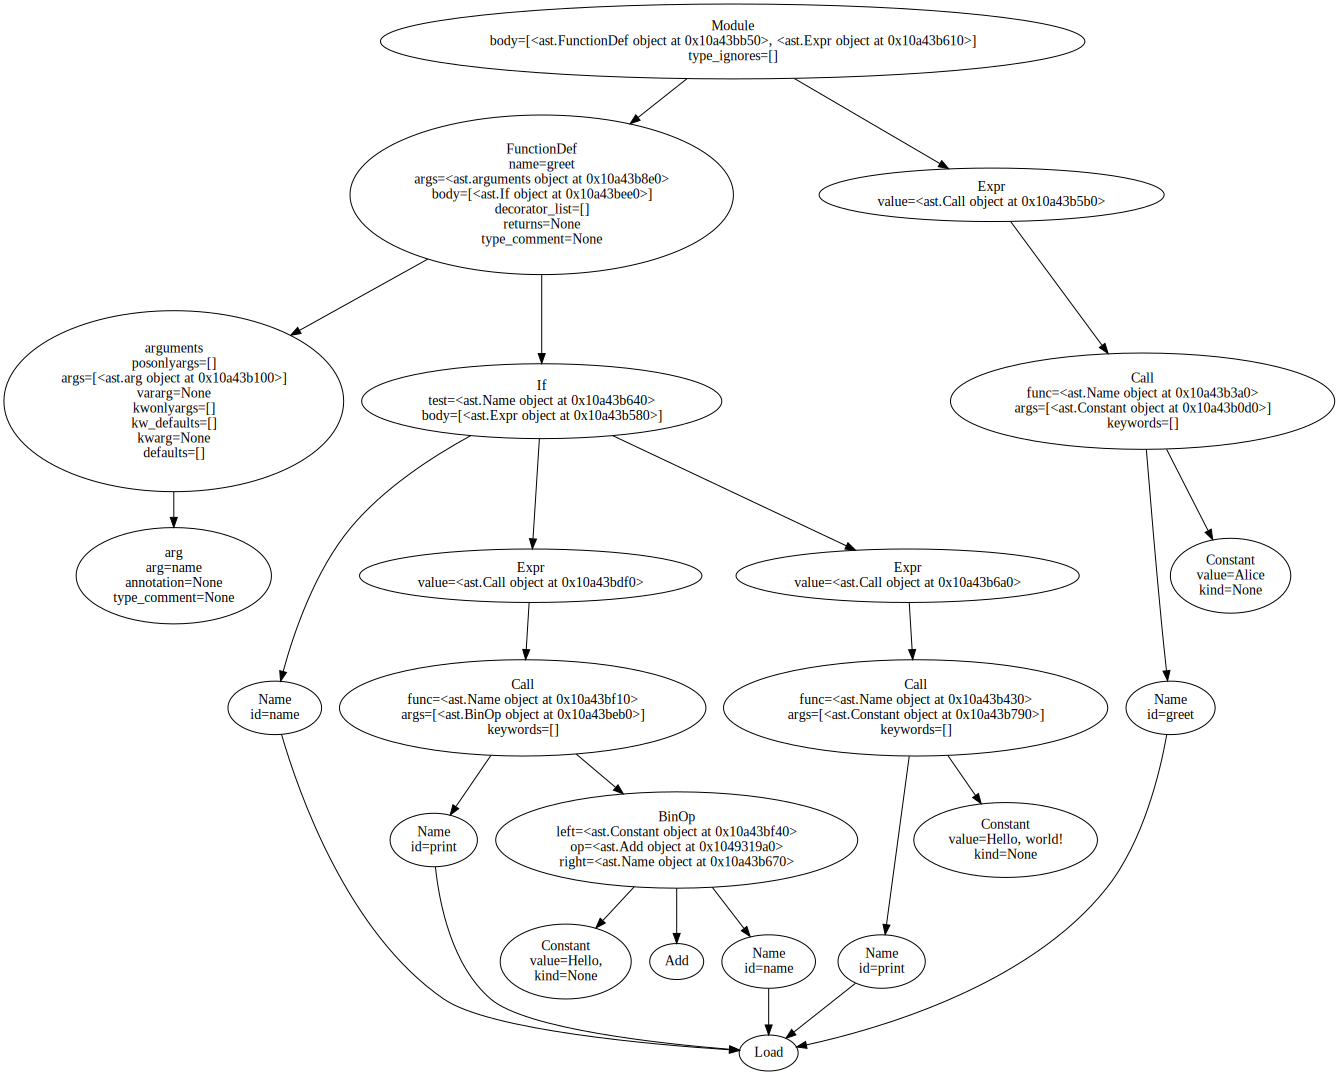

In [23]:
import ast
import graphviz

def create_ast_graph(code):
    tree = ast.parse(code)
    dot = graphviz.Digraph()

    def visit(node, parent_name=None):
        name = str(id(node))
        label = type(node).__name__

        if isinstance(node, ast.AST):
            label += '\n'
            fields = [(field, value) for field, value in ast.iter_fields(node) if field not in ('ctx', 'orelse', 'finalbody')]
            label += '\n'.join(f"{field}={repr(value)}" for field, value in fields)

        dot.node(name, label=label)

        if parent_name is not None:
            dot.edge(parent_name, name)

        for child in ast.iter_child_nodes(node):
            visit(child, name)

    visit(tree)
    return dot

code = """
def greet(name):
    if name:
        print("Hello, " + name)
    else:
        print("Hello, world!")

greet("Alice")
"""
dot = create_ast_graph(code)
# dot.render('syntax_tree', format='png', cleanup=True)
# print("Syntax tree visualization saved as 'syntax_tree.png'")
dot

In [2]:
import sys
import io
from antlr4 import InputStream, CommonTokenStream, ParseTreeWalker, ParserRuleContext
from antlr4.error.ErrorListener import ErrorListener
from antlr4.tree.Tree import ParseTreeVisitor
from antlr4.tree.Trees import Trees
from projector.SmallScript.antlr.SmallScriptLexer import SmallScriptLexer as Lexer
from projector.SmallScript.antlr.SmallScriptParser import SmallScriptParser as Parser
from projector.SmallScript.antlr.SmallScriptVisitor import SmallScriptVisitor as Visitor
from projector.SmallScript.antlr.SmallScriptListener import SmallScriptListener as Listener
from graphviz import Digraph


class DOTGraphListener(Listener):
    def __init__(self):
        self.graph = Digraph('G', format='png')

    def enterEveryRule(self, ctx):
        rule_name = Parser.ruleNames[ctx.getRuleIndex()]
        node_label = f"{rule_name}: {Trees.getNodeText(ctx, Parser.ruleNames)}"
        self.graph.node(str(id(ctx)), node_label)

    def exitEveryRule(self, ctx):
        for child in ctx.getChildren():
            self.graph.edge(str(id(ctx)), str(id(child)))

    def visitTerminal(self, node):
        txt = node.getText()
        if txt.strip() != "":
            print(f"{txt} :{Parser.ruleNames[node.getParent().getRuleIndex()]}")
        self.graph.node(str(id(node)), f"'{node.getText()}'", shape='box')



ModuleNotFoundError: No module named 'projector'

In [308]:
def parseTree(st):
    # ins = io.StringIO(st)
    # lexer = Lexer(ins)
    lexer = Lexer(InputStream(st))
    stream = CommonTokenStream(lexer)
    parser = Parser(stream)
    tree = parser.script()
    # s = tree.toStringTree(recog=parser)
    listener = DOTGraphListener()
    walker = ParseTreeWalker()
    walker.walk(listener, tree)
    return listener.graph

In [ ]:
# st = """abc := -123 + 1.2 + 1.0e-1 + 16r123"""

#
# Tested
#

# assignment & ExpressionList
# st = "var1 := 1"
# st = "var1 := root"
# st = "var1 := 'abc'"
# st = "var1 := root. var2 := var1" 
# st = "a := b := 2"
# st = "var1 := root. var2 := _"

# unarySend & unaryTail
#st = "obj1 attr3 name" 

# keywordSend
# st = "obj1 name: 'abc'"
# st = "obj1 method1__firstname: 'John' lastname: 'Doe'"
# st = "obj1 attr1: 123. obj1 attr1"

# binarySend
# st = "obj1 attr1: 1 + 2"
# st = "obj1 attr1: 1 + 2 + obj1 var1"
# st = "obj1 var1 + 1 + 2"
# st = "obj1 var1 + obj1 var2"
# st = "obj1 method3__var1: 3 + 4 var2: 2 + 3"

# cascade
# st = "7; + 3"
# st = "2; + 1; + 5" # Antlr ok, Amber fail
# st = "obj1 var1; +3"
# st = "obj1; method4 attr7 + 3" # Amber fail as it is mixed unaryMessage and binaryMessage
# st = "obj1; var1 + obj1 method4 attr7" # Amber fail as it is mixed unaryMessage and binaryMessage
# st = "obj1 var2: 7; var2; + 3" # ok
# st = "obj1; method4; method3__var1: 3 var2: 2; + obj1 var1; + 5" # ok

# subexpression
# st = "(obj1 method4 method3__var1: 3 var2: 2) + obj1 var1 + 5"
# st = "(obj := obj1) var1"
# st = """(obj1 m1: 1) + (obj2 m2 m3) + 2"""

# primitive
# st = f"<python: 'def hello:'>"

# BlockClosure
# st = "[ :e | | a | a:= e + 1]" # error
# st = "[ :e | | a | a := e + 1 ]"
# st = "[ :e | | a | e + 1 ]"
# st = "[ | a | e + 1 ]"
# st = "[ :e | e + 1 ]"
st = "[:v1 | v1 + 1] value: 3"

## Working: using Script.graph()
parseTree(st)

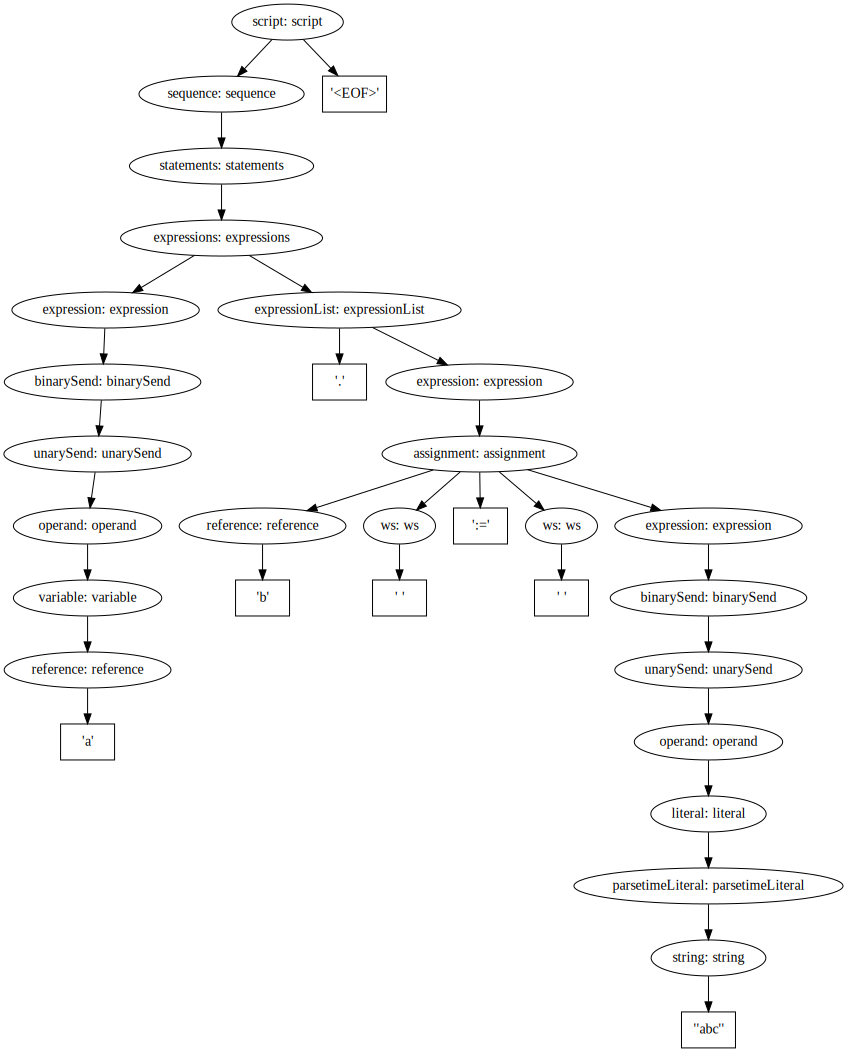

In [10]:
# st = """abc := -123 + 1.2 + 1.0e-1 + 16r123"""

#
# Tested
#

# assignment & ExpressionList
# st = "var1 := 1"
# st = "var1 := root"
# st = "var1 := 'abc'"
st = "var1 := root. var2 := var1" 
# st = "a := b := 2"
# st = "var1 := root. var2 := _"

# unarySend & unaryTail
#st = "obj1 attr3 name" 

# keywordSend
# st = "obj1 name: 'abc'"
# st = "obj1 method1__firstname: 'John' lastname: 'Doe'"
# st = "obj1 attr1: 123. obj1 attr1"

# binarySend
# st = "obj1 attr1: 1 + 2"
# st = "obj1 attr1: 1 + 2 + obj1 var1"
# st = "obj1 var1 + 1 + 2"
# st = "obj1 var1 + obj1 var2"
# st = "obj1 method3__var1: 3 + 4 var2: 2 + 3"

# cascade
# st = "7; + 3"
# st = "2; + 1; + 5" # Antlr ok, Amber fail
# st = "obj1 var1; +3"
# st = "obj1; method4 attr7 + 3" # Amber fail as it is mixed unaryMessage and binaryMessage
# st = "obj1; var1 + obj1 method4 attr7" # Amber fail as it is mixed unaryMessage and binaryMessage
# st = "obj1 var2: 7; var2; + 3" # ok
# st = "obj1; method4; method3__var1: 3 var2: 2; + obj1 var1; + 5" # ok

# subexpression
# st = "(obj1 method4 method3__var1: 3 var2: 2) + obj1 var1 + 5"
# st = "(obj := obj1) var1"
# st = """(obj1 m1: 1) + (obj2 m2 m3) + 2"""

# primitive
# st = f"<python: 'def hello:'>"

# BlockClosure
# st = "[ :e | | a | a:= e + 1]" # error
# st = "| tmp1 tmp2 | tmp1 := obj1 var1. tmp2 := tmp1 + 3. obj1 var2: tmp2 + 5. obj1 var2"
# st = "| tmp1 tmp2 | obj1 var1"
# st = "[2 + 3] value"
# st = "[ :e | 2 + e] value: 9"
# st = "b := [ :e | | a | a := e + 3]. b value: 9"
# st = 'b := [ :e | | a | a "comment" := [2 + 3] value + e]. b value: 9'

# literalArray
# st = 'obj1 := $F'
# st = "#('a' 12 $F true #root #(1 2) + root value: )"

st = "b := [ :e | 2 + e]. b value: 9"
st = 'b := [ :e | | a | a "comment" := [2 + 3] value + e]. b value: 9'
st = "| tmp1 tmp2 | obj1 var1"
# st = "[2 + 3] value"
# st = "#('a' 12 true #root #(1 2) + root value: )"
# st = "obj1 var1; + 3"
# st = "123 toString"
# st = "var1 := root"
# st = "obj1; method4 attr7 + 5"
# st = "obj1 var1; + 3"
# st = "7; + 3; +5"
# st = "7; + 3"
st = "[2 + 3] value"
st = "[:e | 2 + e] value: 13"
# st = "2 + 3. 4 + 5"
# st = "_ := b := 123"
# st = "[:e | 2 + 3 + e]"

# st = "b := [:e | attr1 + e]. self attr2: b. self attr2"
# st = "[[2 + 3] value + [3 - 2] value]"

st = "a.b := 'abc'"

import sys
sys.path.append('..')
from projector.SmallScript.Context import *
from projector.SmallScript.Closure import Script
Script().compile(st).ast_graph()

In [4]:
import importlib.abc
import sys
import os

class CustomFinder(importlib.abc.MetaPathFinder):
    def find_spec(self, fullname, path, target=None):
        if fullname.startswith("my_special_package"):
            return importlib.machinery.ModuleSpec(
                fullname,
                CustomLoader(fullname)
            )
        return None

class CustomLoader(importlib.abc.SourceLoader):
    def __init__(self, fullname):
        self.fullname = fullname

    def get_filename(self, fullname):
        return fullname + ".py"  # Simplified: Normally calculate the path to the file

    def get_data(self, path):
        with open(path, 'r') as file:
            source = file.read()
        print(f"Custom loading for {path}")
        # Here you could add logic to check for recompilation, etc.
        return source

    def exec_module(self, module):
        filename = self.get_filename(self.fullname)
        code = self.source_to_code(self.get_data(filename), filename)
        exec(code, module.__dict__)

# Add the custom finder to the meta-path
sys.meta_path.insert(0, CustomFinder())

# Example usage
# import my_special_package.module  # This would trigger the custom loader


In [10]:
import inspect

class MyClass:
    def method1(selfxxx, param1, param2):
        pass

    def method2(self):
        pass

    @classmethod
    def class_method(cls, param1):
        pass

    @staticmethod
    def static_method(param1):
        pass

# Instance to inspect
obj = MyClass()

# Inspecting methods
for name in dir(MyClass):  # Inspect the class itself to include all types of methods
    attr = getattr(MyClass, name)
    if callable(attr) and not name.startswith('__'):
        # Get signature
        signature = inspect.signature(attr)
        # Extract parameter names
        parameters = list(signature.parameters)
        print(f'Method: {name}, Parameters: {parameters}')

Method: class_method, Parameters: ['param1']
Method: method1, Parameters: ['selfxxx', 'param1', 'param2']
Method: method2, Parameters: ['self']
Method: static_method, Parameters: ['param1']


In [14]:
import inspect

def is_function_or_method(obj):
    if inspect.ismethod(obj):
        return "method"
    elif inspect.isfunction(obj):
        return "function"
    else:
        return "not a function or method"

# Example usage:
class MyClass:
    def instance_method(self):
        pass

    @classmethod
    def class_method(cls):
        pass

    @staticmethod
    def static_method():
        pass

# Testing
print(is_function_or_method(MyClass.instance_method))  # Output: "function" in Python 3, "method" in Python 2
print(is_function_or_method(MyClass().instance_method))  # Output: "method"
print(is_function_or_method(MyClass.class_method))  # Output: "method"
print(is_function_or_method(MyClass.static_method))  # Output: "function"
print(is_function_or_method(lambda x: x * 2))  # Output: "function"

function
method
method
function
function


In [15]:
class MyClass:
    def __init__(self):
        self.attr = "Initial Value"

    def delete_attribute(self):
        delattr(self, 'attr')
        # If you access self.attr after this point in another method,
        # it could be redefined or handled in a way that it reappears.

# Create instance
obj = MyClass()
print(obj.attr)  # Output: Initial Value

# Delete attribute
obj.delete_attribute()
try:
    print(obj.attr)
except AttributeError:
    print("Attribute has been deleted.")

# If we access obj.attr here and it's defined as a property or handled in __getattr__, it might still return a value.


Initial Value
Attribute has been deleted.


In [17]:
obj.__dict__

{}